# **PACKAGE SETUP**

### **Installing and Importing Packages**

In [ ]:
!python -m spacy download en

import string
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

     |████████████████████████████████| 12.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from gensim.models.word2vec import Word2Vec

# **DATASET SETUP AND ANALYSIS**

### **Training, Validation and Test Data**

In [ ]:
train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

### **Data Analysis**

**Data analysis of training data**

In [ ]:
train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444
...,...,...,...,...,...,...,...,...,...,...,...,...
12133,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpyd0,https://www.reddit.com/r/reddit.com/comments/h...,,"If you were God, you'd know whether we would b...",answer,False,1,t3_hzu51,neutral,0.000000
12134,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpz7m,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,If I check my account balance in 5 minutes and...,answer,False,1,t3_hzu51,neutral,0.000000
12135,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq0tl,https://www.reddit.com/r/reddit.com/comments/h...,alllie,I don't know. Can you heal the sick with a tou...,answer,False,1,t3_hzu51,negative,0.637202
12136,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq19j,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,... Give LeBron James a championship ring?,humor,False,2,t1_c1zq0tl,neutral,0.000000


In [ ]:
subreddits = train_data['subreddit']
subreddits.value_counts()

askreddit               3440
leagueoflegends         1548
buildapc                 908
electronic_cigarette     703
pcmasterrace             526
trees                    466
gaming                   441
relationships            431
summonerschool           425
explainlikeimfive        379
whowouldwin              357
movies                   349
jailbreak                343
techsupport              342
personalfinance          291
atheism                  289
hearthstone              284
tipofmytongue            217
reddit.com               204
starcraft                195
Name: subreddit, dtype: int64

**Data analysis of target labels**

In [ ]:
labels = train_data['sentiment.polarity']
labels.value_counts()

neutral          7679
positive         3231
negative          878
very positive     253
very negative      97
Name: sentiment.polarity, dtype: int64

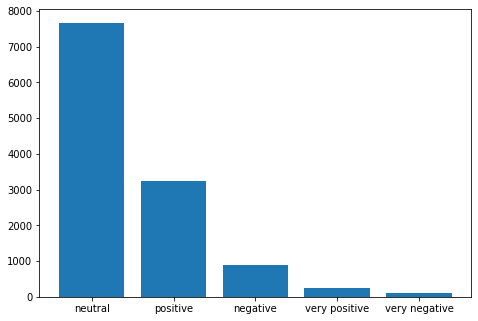

In [ ]:
true_polarity_labels = labels.value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(true_polarity_labels.keys(), true_polarity_labels.values)
plt.show()

# **DATA PRE-PROCESSING**

### **Downloading Pre-trained NLP model and All Stopwords**

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

all_stops = set(stopwords.words('english')) | set(string.punctuation)

In [ ]:
# Displaying the stopwords used in the project

all_stops

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

### **Tokenization and Normalization Functions**

In [ ]:
def spacy_tokenize(str):
  tokens = list()
  doc = nlp(str)
  for token in doc:
    tokens.append(token)
  return tokens

def tokens_normalize(str):
  normalized_tokens = list()
  tokens = spacy_tokenize(str)  
  for token in tokens:
    if (token.is_alpha):
      lemma = token.lemma_.lower().strip() if token.lemma_ != '-PRON-' else token.lower_
      if (lemma not in all_stops):
        normalized_tokens.append(lemma)
  return normalized_tokens

### **Tokenizing and Normalizing Posts in the Train Data**

In [ ]:
train_data['body']

0                        It's a sad realization, isn't it?
1        I told her a couple of minutes ago that I didn...
2                        Leeches don't make good friends. 
3        I just ended it. Apparently she wasn't a good ...
4             Good for you!  Make sure you stick with it. 
                               ...                        
12133    If you were God, you'd know whether we would b...
12134    If I check my account balance in 5 minutes and...
12135    I don't know. Can you heal the sick with a tou...
12136           ... Give LeBron James a championship ring?
12137              Well, if you believed it, that'd be one
Name: body, Length: 12138, dtype: object

In [ ]:
# Tokenized and normalized train data

tokenize_all_posts = train_data.body.apply(tokens_normalize)
tokenize_all_posts

0                                       [sad, realization]
1        [tell, couple, minute, ago, want, continue, an...
2                            [leeches, make, good, friend]
3        [end, apparently, good, friend, even, bother, ...
4                                [good, make, sure, stick]
                               ...                        
12133                 [god, know, whether, would, believe]
12134    [check, account, balance, minute, believe, wor...
12135    [know, heal, sick, touch, make, blind, able, s...
12136            [give, lebron, james, championship, ring]
12137                                 [well, believe, one]
Name: body, Length: 12138, dtype: object

### **Label Encoding**

In [ ]:
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(train_data['sentiment.polarity'])
train_labels = labelencoder.transform(train_data['sentiment.polarity'])
validation_labels = labelencoder.transform(validation_data['sentiment.polarity'])
test_labels = labelencoder.transform(test_data['sentiment.polarity'])

In [ ]:
train_data['sentiment.polarity']

0        negative
1         neutral
2        positive
3        positive
4        positive
           ...   
12133     neutral
12134     neutral
12135    negative
12136     neutral
12137     neutral
Name: sentiment.polarity, Length: 12138, dtype: object

In [ ]:
# Label encoded data

train_labels

array([0, 1, 2, ..., 0, 1, 1])

# **TRAINING AND EVALUATION USING DIFFERENT CLASSIFIERS**

### **Evaluation Function Based on Precision, Recall, Accuracy and F1 Score**

In [ ]:
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro', zero_division=0)
  recall = recall_score(predictions, true_labels, average='macro', zero_division=0)
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, beta=1, average='macro', zero_division=0)
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))

### **One-Hot Vectorization**

In [ ]:
one_hot_vectorizer = CountVectorizer(tokenizer=tokens_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

### **Dummy Classifier with strategy="stratified"**

In [ ]:
dummy_str = DummyClassifier(strategy='stratified')
dummy_str.fit(train_features, train_labels)
evaluation_summary('Dummy Stratified', dummy_str.predict(test_features), test_labels)

Evaluation for: Dummy Stratified
Classifier 'Dummy Stratified' has Acc=0.474 P=0.193 R=0.193 F1=0.193


### **Dummy Classifier with strategy="most_frequent"**

In [ ]:
dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)
evaluation_summary('Dummy Most Frequent', dummy_mf.predict(test_features), test_labels)

Evaluation for: Dummy Most Frequent
Classifier 'Dummy Most Frequent' has Acc=0.626 P=0.200 R=0.125 F1=0.154


### **LogisticRegression with One-Hot Vectorization**

In [ ]:
lr_one_hot = LogisticRegression(max_iter=1000)
lr_one_hot_model = lr_one_hot.fit(train_features, train_labels)
evaluation_summary('LR One-hot', lr_one_hot_model.predict(test_features), test_labels)

Evaluation for: LR One-hot
Classifier 'LR One-hot' has Acc=0.719 P=0.400 R=0.588 F1=0.445


### **SVC Classifier with One-Hot Vectorization**

In [ ]:
svc = SVC(kernel='rbf')
svc_model = svc.fit(train_features, train_labels)
evaluation_summary('SVC One-hot', svc_model.predict(test_features), test_labels)

Evaluation for: SVC One-hot
Classifier 'SVC One-hot' has Acc=0.736 P=0.320 R=0.413 F1=0.332


### **TF-IDF Vectorization**

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokens_normalize)
train_features_tf = tf_idf_vectorizer.fit_transform(train_data['body'])
validation_features_tf = tf_idf_vectorizer.transform(validation_data['body'])
test_features_tf = tf_idf_vectorizer.transform(test_data['body'])

### **LogisticRegression with TF-IDF Vectorization**

In [ ]:
lr_tf_idf = LogisticRegression(max_iter=10000)
lr_tf_idf_model = lr_tf_idf.fit(train_features_tf, train_labels)
evaluation_summary('LR TF-IDF', lr_tf_idf_model.predict(test_features_tf), test_labels)

Evaluation for: LR TF-IDF
Classifier 'LR TF-IDF' has Acc=0.727 P=0.323 R=0.607 F1=0.345


### **Evaluating the Classifiers Based on Weighted Average of the Evaluation Metrics**

In [ ]:
model_names = ['Dummy Classifier_ST', 'Dummy Classifier_MF', 'LogisticRegression_OneHot', 'LogisticRegression_TFIDF', 'SVC Classifier']

models = [dummy_str, dummy_mf, lr_one_hot_model, lr_tf_idf_model, svc_model]

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model in models:
  if model == lr_tf_idf_model:
    test_f = test_features_tf
  else:
    test_f = test_features
  accuracy_list.append(accuracy_score(model.predict(test_f), test_labels))
  precision_list.append(precision_score(model.predict(test_f), test_labels, average='weighted', zero_division=0))
  recall_list.append(recall_score(model.predict(test_f), test_labels, average='weighted', zero_division=0))
  f1_list.append(fbeta_score(model.predict(test_f), test_labels, beta=1, average='weighted', zero_division=0))

### **Best Performing Classifier (By Weighted F1 in Test Set)**

In [ ]:
dict = {
    'Models' : model_names,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
}

df = pd.DataFrame(dict)

def highlight_max(s, max_val, column):
  is_max = pd.Series(data=False, index=s.index)
  is_max[column] = s.loc[column] == max_val
  return ['background-color: yellow' if is_max.any() else '' for val in is_max]
  
df.style.apply(highlight_max, max_val=df['F1 Score'].max(), column=['F1 Score'], axis=1)

,Models,Accuracy,Precision,Recall,F1 Score
0,Dummy Classifier_ST,0.468625,0.476979,0.476096,0.473140
1,Dummy Classifier_MF,0.625996,1.000000,0.625996,0.769985
2,LogisticRegression_OneHot,0.719373,0.767465,0.719373,0.737169
3,LogisticRegression_TFIDF,0.726594,0.828421,0.726594,0.763287
4,SVC Classifier,0.736305,0.831549,0.736305,0.771831


### **F1 Score for Each Class of the Best Performing Classifier**

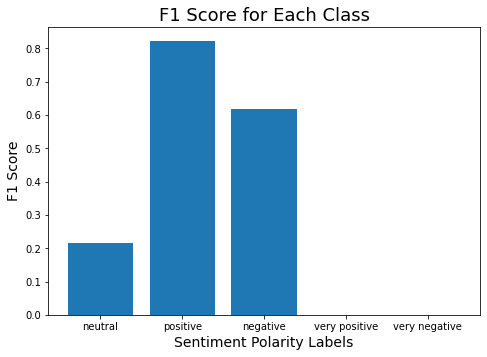

In [ ]:
best_model = models[df.index[df['F1 Score'] == df['F1 Score'].max()].tolist()[0]]
if best_model == lr_tf_idf_model:
  test_f = test_features_tf
else:
  test_f = test_features
f1_score_perClass = f1_score(best_model.predict(test_f), test_labels, average=None)

polarity_labels = labels.value_counts().index
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(polarity_labels, f1_score_perClass)
ax.set_title('F1 Score for Each Class', fontsize=18)
ax.set_xlabel('Sentiment Polarity Labels', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
plt.show()

### **Baseline TF-IDF Logistic Regression Model**

In [ ]:
baseline_model = Pipeline(steps=[
                 ('tfidf', TfidfVectorizer(tokenizer=tokens_normalize)),
                 ('lr', LogisticRegression(max_iter=10000))
])
baseline_model.fit(train_data['body'], train_labels)

evaluation_summary('Baseline TF-IDF Model', baseline_model.predict(test_data['body']), test_labels)

Evaluation for: Baseline TF-IDF Model
Classifier 'Baseline TF-IDF Model' has Acc=0.727 P=0.323 R=0.607 F1=0.345


### **Hyperparamter Tuning TF-IDF Logistic Regression Model**

In [ ]:
start_time = time.time()

print('----Started Tuning----')

tuned_Model = Pipeline(steps=[
                 ('tfidf', TfidfVectorizer(tokenizer=tokens_normalize)),
                 ('lr', LogisticRegression(max_iter=10000))
])

param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_features': [None, 1000, 5000, 10000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [.001, .1, 1.0, 10.0, 10000.0]
}

best_f1_score = fbeta_score(baseline_model.predict(validation_data['body']), validation_labels, beta=1, average='macro', zero_division=0)

for param in ParameterGrid(param_grid):
  tuned_Model.set_params(**param)
  tuned_Model.fit(train_data['body'], train_labels)

  pred = tuned_Model.predict(validation_data['body'])
  f1_score = fbeta_score(pred, validation_labels, beta=1, average='macro', zero_division=0)

  if f1_score > best_f1_score:
    best_f1_score = f1_score
    best_parameters = param
    print('Current Best Score: %0.3f' % best_f1_score)

time_elapsed = time.time() - start_time
print('\nTuning completed in :', str(datetime.timedelta(seconds=time_elapsed)).split(".")[0])
print("Best score : %0.3f" % best_f1_score)
print("Best parameters set:")
for param_name in sorted(param_grid.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

----Started Tuning----
Current Best Score: 0.348
Current Best Score: 0.408
Current Best Score: 0.443
Current Best Score: 0.478

Tuning completed in : 0:47:48
Best score : 0.478
Best parameters set:
	lr__C: 10.0
	tfidf__max_features: 1000
	tfidf__ngram_range: (1, 1)
	tfidf__sublinear_tf: True


### **Best Tuned TF-IDF Logistic Regression Model**

In [ ]:
best_tunedModel = Pipeline(steps=[
                 ('tfidf', TfidfVectorizer(tokenizer=tokens_normalize)),
                 ('lr', LogisticRegression(max_iter=10000))
])
best_tunedModel.set_params(**best_parameters)
best_tunedModel.fit(train_data['body'], train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, sublinear_tf=True,
                                 tokenizer=<function tokens_normalize at 0x7fbc826feb90>)),
                ('lr', LogisticRegression(C=10.0, max_iter=10000))])

### **Evaluating Baseline and Tuned TF-IDF Logistic Regression Model**

In [ ]:
evaluation_summary('Baseline TF-IDF Model', baseline_model.predict(test_data['body']), test_labels)
evaluation_summary('Best Tuned TF-IDF Model', best_tunedModel.predict(test_data['body']), test_labels)

Evaluation for: Baseline TF-IDF Model
Classifier 'Baseline TF-IDF Model' has Acc=0.727 P=0.323 R=0.607 F1=0.345
Evaluation for: Best Tuned TF-IDF Model
Classifier 'Best Tuned TF-IDF Model' has Acc=0.736 P=0.447 R=0.601 F1=0.496


In [ ]:
predicted_value = best_tunedModel.predict(['Feels so happy about the course'])
predicted_label = labelencoder.inverse_transform(predicted_value)
predicted_label[0]

'positive'

### **Word Emdedding on the Train and Test Data**

In [ ]:
tokenize_all_trainData = train_data.body.apply(tokens_normalize)
trainData_tokens = tokenize_all_trainData.values
tokenize_all_testData = test_data.body.apply(tokens_normalize)
testData_tokens = tokenize_all_testData.values

train_word2vec_model = Word2Vec(trainData_tokens, min_count = 1, size = 1000, workers = 3, window = 3, sg = 1)
test_word2vec_model = Word2Vec(testData_tokens, min_count = 1, size = 1000, workers = 3, window = 3, sg = 1)

def createEmbeddedFeatures(data_tokens, word2vec_model):
  embeddedFeatures = []
  for tokens in data_tokens:
    if tokens:
      vectors = (np.mean([word2vec_model.wv[token] for token in tokens], axis=0)).tolist()
    if type(vectors) is list:
      embeddedFeatures.append(vectors)
    else:
      embeddedFeatures.append(np.array([0 for i in range(1000)]))
  return embeddedFeatures

train_embeddedFeatures = createEmbeddedFeatures(trainData_tokens, train_word2vec_model)
test_embeddedFeatures = createEmbeddedFeatures(testData_tokens, test_word2vec_model)

### **Training and Evaluating Embedded Data using Logistic Regression Classifier**

In [ ]:
lr_embedding = LogisticRegression(C=10.0, max_iter=10000)
lr_embedding_model = lr_embedding.fit(train_embeddedFeatures, train_labels)
evaluation_summary('Word Embedded LR Model', lr_embedding_model.predict(test_embeddedFeatures), test_labels)

Evaluation for: Word Embedded LR Model
Classifier 'Word Embedded LR Model' has Acc=0.626 P=0.200 R=0.125 F1=0.154


### **Saving the Best Trained Model and the Label Encoder**

In [ ]:
file = open('sentiment_classifier.pkl', 'wb')
joblib.dump(best_tunedModel, file)

In [ ]:
file = open('label_encoder.pkl', 'wb')
joblib.dump(labelencoder, file)